In [51]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
X_test = []

In [72]:
TEST_PATH = "/content/drive/MyDrive/Park_gauss_resnet_testset/testing/HC_gauss/"
for imagenameindir in os.listdir(TEST_PATH):
    # print(imagenameindir)
    img = image.load_img(TEST_PATH+'/'+imagenameindir,target_size=(256,256))
    img = np.asarray(img)
    X_test.append(img)


In [ ]:
print((X_test[0]))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

testAug = ImageDataGenerator()

In [5]:
BS=64

testGen = testAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(256, 256),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 1203 images belonging to 2 classes.


In [5]:
print(testGen.classes)

[0 0 0 ... 1 1 1]


In [7]:
#loading the two models
model1 = load_model("/content/drive/MyDrive/best_model/park_best_resnet.h5")
model2 = load_model("/content/drive/MyDrive/BestModel/Park_best_vgg.h5")

In [11]:
#summing
models = [model1, model2]
preds = [model.predict(testGen) for model in models]
preds= np.array(preds)
summed = np.sum(preds, axis=0)

In [12]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)
print(ensemble_prediction)

[0 0 0 ... 1 1 1]


In [ ]:
#prediction on models individually
prediction1 = model1.predict(testGen)
prediction2 = model2.predict(testGen)

In [16]:
#argmax across classes
pred1 = np.argmax(prediction1, axis=1)
pred2 = np.argmax(prediction2, axis=1)

print(pred1)

[0 0 0 ... 0 1 1]


In [17]:
#comparing normal and ensemble accuracies
accuracy1 = accuracy_score(testGen.classes, pred1)
accuracy2 = accuracy_score(testGen.classes, pred2)

ensemble_accuracy = accuracy_score(testGen.classes, ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.9218620116375728
Accuracy Score for model2 =  0.9019118869492935
Accuracy Score for average ensemble =  0.9609310058187863


In [47]:

ideal_weights = [0.5, 0.5] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(testGen.classes, ideal_weighted_ensemble_prediction)


Predicted Label:  PD
True Label:  PD


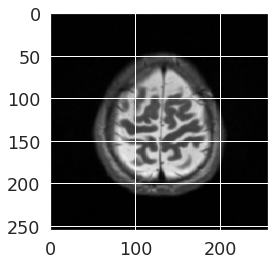

In [87]:
class_names = ['HC', 'PD']
i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(X_test[i]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[int(testGen.classes[i])])



#PLot fractional incorrect misclassifications
# incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
# fig, ax = plt.subplots(figsize=(12,12))
# plt.bar(np.arange(24), incorr_fraction)
# plt.xlabel('True Label')
# plt.ylabel('Fraction of incorrect predictions')
# plt.xticks(np.arange(24), class_names) 

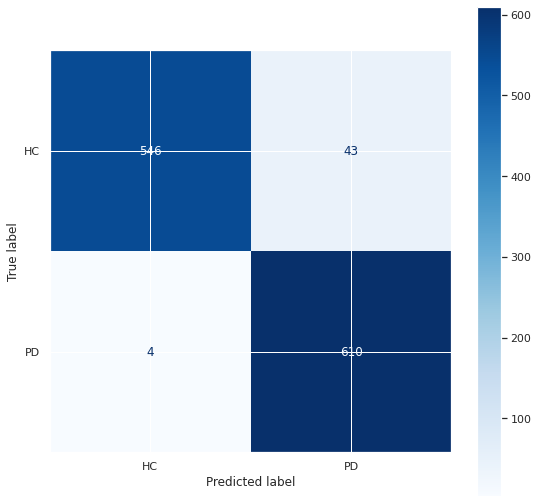

In [125]:
#@title /####/ FINAL CELL /####/ { form-width: "30%", display-mode: "both" }
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(testGen.classes, ideal_weighted_ensemble_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(9,9))
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontname('Arial')
#     label.set_fontsize(18)
sns.set(font_scale=1.0)
# plt.rcParams.update({'font.size': 20})
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()



# sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, xticklabels=class_names, yticklabels=class_names)

# **END** 

Weighted average

In [19]:
#@title Default title text
#Weighted average ensemble
models = [model1, model2]
preds = [model.predict(testGen) for model in models]
preds = np.array(preds)



In [42]:
weights = [0.6, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(testGen.classes, weighted_ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.9218620116375728
Accuracy Score for model2 =  0.9019118869492935
Accuracy Score for average ensemble =  0.9609310058187863
Accuracy Score for weighted average ensemble =  0.940149625935162


In [43]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2]
preds1 = [model.predict(testGen) for model in models]
preds1=np.array(preds1)


In [ ]:
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 9):
    for w2 in range(0,9):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(testGen.classes, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)


In [44]:
max_acc_row = df.iloc[df['acc'].idxmax()]
print(max_acc_row)

print("Max accuracy of ", max_acc_row[2], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1])         

wt1     0.600000
wt2     0.700000
acc    96.591854
Name: 61, dtype: float64
Max accuracy of  96.59185369908562  obained with w1= 0.6  w2= 0.7


In [ ]:
### Explore metrics for the ideal weighted ensemble model. 

models = [model1, model2]
preds = [model.predict(testGen) for model in models]
preds=np.array(preds)